In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')

from missingpy import KNNImputer
from cleaning import cleaning
import error_function

from lasso import rmse_cv,Lasso_importance

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn

from pysurvival.models.survival_forest import ExtraSurvivalTreesModel#pip install pysurvival
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score

Extra survival trees model:
https://square.github.io/pysurvival/models/survival_forest.html

Steps:
1. clean the data (missing data + binary/target encoding + normalization)
2. select the columns with lasso regression
3. train a ExtraST model
4. compute the error
5. reselect the columns with high importance
6. retrain the model
7. compute final error and final selected features
8. train the model with the whole dataset
9. export the model and features.

In [2]:
X_train, X_test, y_train, y_test = cleaning('train.csv', 0.2)


In [3]:
X_test.head()

,patient_gender,patient_eye_color,patient_hair_color,patient_phototype,primary_tumour_location_coded,T0_date,cutaneous_biopsy_breslow,cutaneous_biopsy_ulceration,cutaneous_biopsy_satellitosis,cutaneous_biopsy_vascular_invasion,...,LAB2679,LAB4176,neutrofils_per_limfocits,limfocits_per_monocits,LABGF_filtrat_glomerular,missLymp,missLAB,missBIO,missBIO2,missNEU
1159,1,0.000000,0.000000,0.0,0.559139,0.002481,0.031667,103.969494,0,0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1.0,1.0,1.0,1.0
2017,1,0.000000,0.000000,0.0,0.253265,0.007940,0.003333,103.969494,0,0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1.0,0.0,0.0,1.0
978,0,0.225707,0.128812,0.6,0.493579,0.002978,0.031333,103.969494,0,0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1.0,0.0,0.0,1.0
759,0,0.000000,0.000000,0.0,0.314873,0.000496,0.005000,103.969494,0,0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,1.0,0.0,0.0,1.0
874,0,0.000000,0.000000,0.0,0.314873,0.002978,0.003333,103.969494,0,0,...,0.007364,0.132678,0.063272,0.025074,0.41237,0.0,0.0,0.0,0.0,0.0


Lasso set coefficient equal to 0 to 2 features out of 54


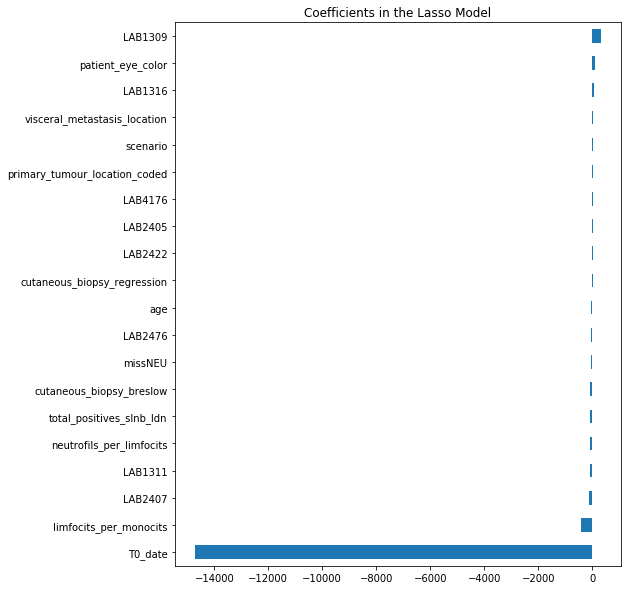

In [20]:
# Feature selection

coefs = Lasso_importance(X_train, y_train.months_survival)

In [21]:
coefs.sort_values(ascending=False, inplace=True)


In [22]:
selected_columns = coefs[np.abs(coefs)>0].index

In [23]:
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]

In [24]:
def fit_model(x_train, y_train,x_test,y_test, plot=True):
    # Building the model
    xst = ExtraSurvivalTreesModel(num_trees=200)
    # Fit model
    xst.fit(x_train, y_train.months_survival.values, y_train.specific_death.values,
            max_features="sqrt", max_depth=50, min_node_size=10, seed=42)
    
    if plot:
        #### - Cross Validation / Model Performances
        c_index = concordance_index(xst,  x_test.values, y_test.months_survival.values,y_test.specific_death.values) #0.81
        print('C-index: {:.2f}'.format(c_index))


        ibs = integrated_brier_score(xst, x_test.values, y_test.months_survival.values,y_test.specific_death.values
                    , t_max=30,figure_size=(20, 6.5) )
        print('IBS: {:.2f}'.format(ibs))

    return xst

C-index: 0.82


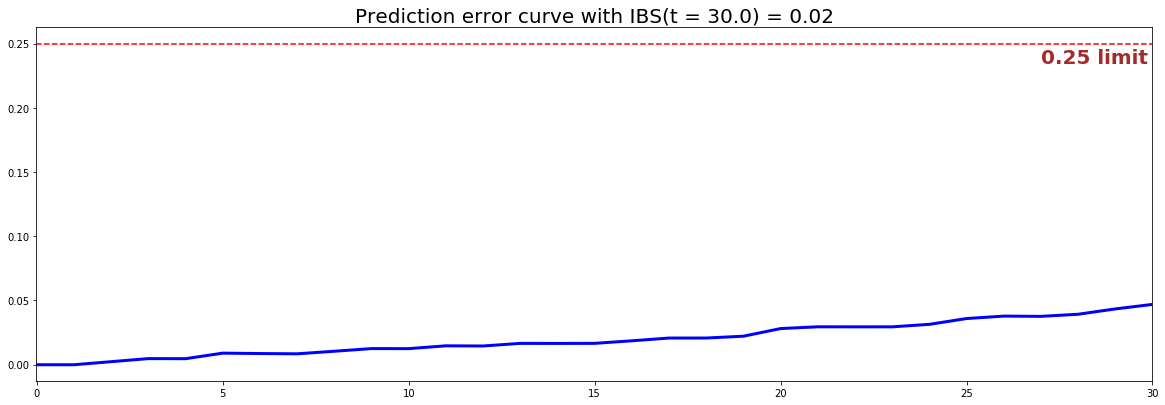

IBS: 0.02


In [25]:
estimator = fit_model(X_train_selected, y_train, X_test_selected,y_test)

In [26]:
def get_probabilities(x_test, estimator):
    
    # Create an empty pandas dataframes with these times as the columns
    pred = estimator.predict_survival(x_test.values[0, :]).flatten()
    times = np.arange(pred.shape[0])
    pred_df = pd.DataFrame(columns = times )
    
    # Convert each row to a pandas series row (transpose) with the index as these x times and append it to the df
    for i in range(0,len(x_test)):
        pred = estimator.predict_survival(x_test.values[i, :])
        pred_df = pred_df.append(pd.DataFrame(pred)) 

    pred_df = pred_df.set_index(np.arange(pred_df.shape[0]))

    return pred_df,times

In [27]:
#  store the probability curves
predictions,times = get_probabilities(X_test_selected, estimator)
predictions2,times = get_probabilities(X_test, estimator)
  

In [28]:
#Calculate error

weights = error_function.calc_weights(y_test) 
error = error_function.brier_score_loss_weighted(pred = predictions,actual = y_test, weights = weights)
error2 = error_function.brier_score_loss_weighted(pred = predictions2,actual = y_test, weights = weights)



print("Overall error: ", error)
print("Overall error2: ", error2)


Overall error:  0.05760478560575769
Overall error2:  0.05760478560575769


In [29]:
X_train.shape

(1718, 54)

In [31]:
importance = pd.DataFrame(estimator.variable_importance.values(), index =  estimator.variable_importance.keys(),
                          columns =['importance'])
importance.sort_values(by="importance", ascending=False, inplace=True)


selected_columns = importance[abs(importance.importance)>0].index
importance

,importance
cutaneous_biopsy_ulceration,16.945124
scenario,15.520163
cutaneous_biopsy_histological_subtype,13.544637
cutaneous_biopsy_breslow,10.426852
total_count_slnb_ldn,8.948453
patient_eye_color,7.675007
visceral_metastasis_location,6.661023
age,6.592799
cutaneous_biopsy_lymphatic_invasion,6.444807
total_positives_slnb_ldn,6.149525


C-index: 0.82


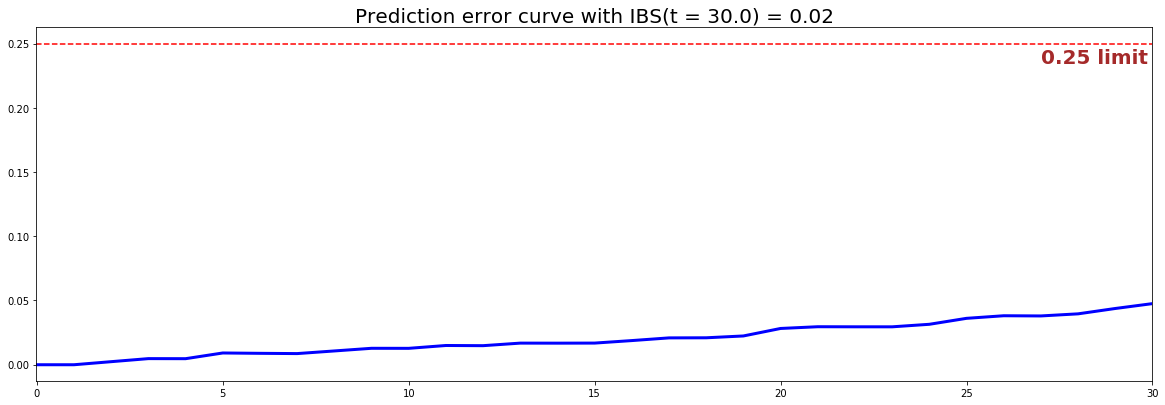

IBS: 0.02
Overall error:  0.05783004873269173


Index(['cutaneous_biopsy_ulceration', 'scenario',
       'cutaneous_biopsy_histological_subtype', 'cutaneous_biopsy_breslow',
       'total_count_slnb_ldn', 'patient_eye_color',
       'visceral_metastasis_location', 'age',
       'cutaneous_biopsy_lymphatic_invasion', 'total_positives_slnb_ldn',
       'cutaneous_biopsy_mitotic_index', 'cutaneous_biopsy_vascular_invasion',
       'patient_phototype', 'cutaneous_biopsy_satellitosis',
       'patient_hair_color', 'MC1R', 'patient_gender',
       'primary_tumour_location_coded', 'limfocits_per_monocits', 'LAB1309',
       'cutaneous_biopsy_regression', 'LAB1307', 'neutrofils_per_limfocits',
       'LAB1301', 'LAB2404', 'LAB2467', 'cutaneous_biopsy_neurotropism',
       'LAB2544', 'cutaneous_biopsy_associated_nevus', 'missLAB', 'missBIO2',
       'LAB2679', 'LAB2476', 'LABGF_filtrat_glomerular', 'T0_date', 'LAB2469',
       'count_inv_prec_tumour', 'LAB1314', 'LAB2422', 'LAB4176', 'LAB2498',
       'LAB1311', 'missBIO', 'LAB2406', 'LAB240

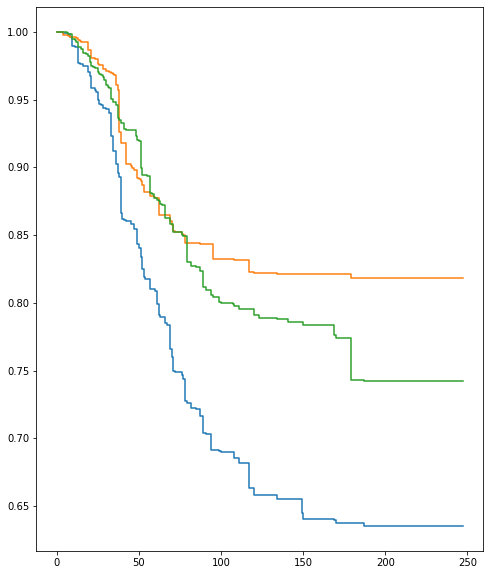

In [32]:
#We reselect the columns with high importance and retrain the model to decrease the complexity of the model
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]

estimator = fit_model(X_train_selected, y_train, X_test_selected,y_test)

predictions,times = get_probabilities(X_test_selected, estimator)

# Plot survival curves for certain observations (here we take first 3 observations)
for curve in predictions.values[0:3]:
    plt.step(times, curve, where="post")
    
weights = error_function.calc_weights(y_test) 
error = error_function.brier_score_loss_weighted(pred = predictions,actual = y_test, weights = weights)


print("Overall error: ", error)

selected_columns

In [34]:
#  store the probability curves
predictions,times = get_probabilities(X_test_selected, estimator)
predictions2,times = get_probabilities(X_test, estimator)

weights = error_function.calc_weights(y_test) 
error = error_function.brier_score_loss_weighted(pred = predictions,actual = y_test, weights = weights)
error2 = error_function.brier_score_loss_weighted(pred = predictions2,actual = y_test, weights = weights)



print("Overall error: ", error)
print("Overall error2: ", error2)

Overall error:  0.05783004873269173
Overall error2:  0.16528389096144785


In [19]:
#Retrain model with train + test sets

X_data = pd.concat([X_train_selected,X_test_selected])
y_data = pd.concat([y_train,y_test])
estimator = fit_model(X_data, y_data, X_test_selected,y_test, plot=False)


In [22]:
from pysurvival.utils import save_model
save_model(estimator, '/home/laia/Escriptori/Master/Agile Data Science/Project/ExtraST_model.zip')

pd.DataFrame(selected_columns).to_csv("Features_ExtraST_model.csv")

Saving the model to disk as /home/laia/Escriptori/Master/Agile Data Science/Project/ExtraST_model.zip


In [21]:
from pysurvival.utils import load_model
estimator_loaded = load_model('/home/laia/Escriptori/Master/Agile Data Science/Project/ExtraST_model.zip')

Loading the model from /home/laia/Escriptori/Master/Agile Data Science/Project/ExtraST_model.zip
